In [1]:
from dask.distributed import Client

client = Client()
# client = Client("tcp://127.0.0.1:36005")
client

Client Scheduler: tcp://127.0.0.1:44737 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 33.58 GB


In [2]:
import cudf, cuml
from cuml import KMeans, UMAP
from dask import delayed
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from chembl_webresource_client.new_client import new_client
from chembl_webresource_client.utils import utils
from PIL import Image
import numpy as np
import os, sys, wget, gzip
import hashlib
from ftplib import FTP
import matplotlib.pyplot as plt
import progressbar

# ChEMBL Search
Illustrating the efficient lazy search and retrieval API for ChEMBL

In [3]:
molecule = new_client.molecule

# filter for approved drugs, filter for molfile present
approved_drugs = molecule.filter(max_phase=4).filter(molecule_structures__isnull=False)

# filter for all small molecules, filter for molfile present
small_molecules = molecule.filter(molecule_type='Small molecule').filter(molecule_structures__isnull=False)

print(len(approved_drugs))
print(len(small_molecules))

3322
1914279


# RDKit MolFromMolBlock
We've filtered above to ensure that molecule structure is present.  From the molfile, we can get an RDKit mol.

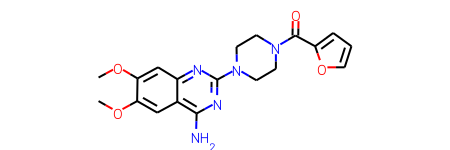

In [4]:
mol = approved_drugs[0]['molecule_structures']['molfile']
m = Chem.MolFromMolBlock(mol)
m

# Fingerprint to Array
The 4 in ECFP4 corresponds to the diameter of the atom environments considered, while the Morgan fingerprints take a radius parameter. So a Morgan fingerprint with radius=2 is roughly equivalent to ECFP4 and FCFP4.

In [5]:
# Get a ECFP4/Morgan fingerprint
mol = approved_drugs[0]['molecule_structures']['molfile']
m = Chem.MolFromMolBlock(mol)
fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2)
ar = np.array(fp)
ar

array([0, 0, 0, ..., 0, 0, 0])

# List of BitVectors
Let's just get a list of a few fingerprints so we can test putting into a DataFrame

In [6]:
fingerprints = []
max_mols = 20

for chembl_mol in approved_drugs[:max_mols]:
    # Get a ECFP4/Morgan fingerprint
    mol = chembl_mol['molecule_structures']['molfile']
    m = Chem.MolFromMolBlock(mol)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2)
    ar = np.array(fp)
    fingerprints.append(ar)

fingerprints = np.asarray(fingerprints, dtype=np.float32)
len(fingerprints)

20

# cuDF GPU DataFrame of Fingerprints
This is a test of a function to convert a list of fingerprints to a GPU DataFrame

In [7]:
def np2cudf(df):
    # convert numpy array to cuDF dataframe
    df = pd.DataFrame({'fea%d'%i:df[:,i] for i in range(df.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

gdf = np2cudf(fingerprints)
gdf.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering with K-Means

In [8]:
n_clusters = 3

kmeans_float = KMeans(n_clusters=n_clusters)
kmeans_float.fit(gdf)

KMeans(handle=<cuml.common.handle.Handle object at 0x7f67999d9eb0>, n_clusters=3, max_iter=300, tol=0.0001, verbose=4, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [9]:
print("labels:")
print(kmeans_float.labels_)
print("cluster_centers:")
print(kmeans_float.cluster_centers_)

labels:
0     0
1     0
2     2
3     0
4     0
5     0
6     0
7     2
8     2
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
dtype: int32
cluster_centers:
   0      1     2     3     4     5     6     7     8     9     ...    2038  \
0   0.0  0.125   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0625   
1   0.0  0.000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0000   
2   0.0  0.000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0000   

   2039  2040  2041  2042  2043  2044      2045  2046  2047  
0   0.0   0.0   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  
1   0.0   0.0   0.0   0.0   1.0   0.0  0.000000   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0  0.333333   0.0   0.0  

[3 rows x 2048 columns]


# Dask Computation of Fingerprints
The first time this is run, the ChEMBL molecules will be downloaded so it will take a while.  The data is automatically cached.  The next time it is run, this should only take about a minute.

In [10]:
def GetMorganFP(chembl_mol, radius=2):
    molfile = chembl_mol['molecule_structures']['molfile']
    m = Chem.MolFromMolBlock(molfile)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius)
    ar = np.array(fp)
    return ar


def ToNpArray(fingerprints):
    fingerprints = np.asarray(fingerprints, dtype=np.float32)
    return fingerprints

In [11]:
fingerprints = []
max_mols = 100

for x in approved_drugs[:max_mols]:
    y = delayed(GetMorganFP)(x)
    fingerprints.append(y)

In [12]:
fingerprints = delayed(ToNpArray)(fingerprints)

results = fingerprints.compute()
print(results.shape)

(100, 2048)


# Saving SMILES Strings
This is inefficient.  The [ftp site](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_26) is a better way to download ChEMBL data.  There, 2048 radius-2 Morgan FPS, SMILES, InChI etc can be downloaded directly.

In [13]:
I_really_want_to_do_this = False

if I_really_want_to_do_this:
    
    fn_aprvd_mols = 'aprvd_molecule_smiles.txt'
    fn_small_mols = 'small_molecule_smiles.txt'
    with open(fn_aprvd_mols,'w') as fp:
        for compound in approved_drugs:
            fp.write(compound['molecule_structures']['canonical_smiles']+'\n')
    with open(fn_small_mols,'w') as fp:
        for compound in small_molecules:
            fp.write(compound['molecule_structures']['canonical_smiles']+'\n')

# Download SMILES from FTP

In [14]:
chemreps_url = 'ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_26/chembl_26_chemreps.txt.gz'
chemreps_local_path = '/data/chembl_26_chemreps.txt.gz'
chemreps_sha256 = '0585b113959592453c2e1bb6f63f2fc9d5dd34be8f96a3a3b3f80e78d5dbe1bd'
chemreps_exists_and_is_good = False

while not chemreps_exists_and_is_good:
    if os.path.exists(chemreps_local_path):
        with open(chemreps_local_path, 'rb') as file:
            local_sha256 = hashlib.sha256(file.read()).hexdigest()
        if chemreps_sha256==local_sha256:
            chemreps_exists_and_is_good = True
            print('chembl chemreps file found locally, SHA256 matches')
    if not chemreps_exists_and_is_good:
        print('downloading chembl chemreps file...')
        wget.download(chemreps_url, chemreps_local_path)

chembl chemreps file found locally, SHA256 matches


# Morgan fingerprints from saved SMILES strings

In [15]:
def MorganFromSmiles(smiles, radius=2, nBits=512):
    m = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits)
    ar = np.array(fp)
    return ar


def ToNpArray(fingerprints):
    fingerprints = np.asarray(fingerprints, dtype=np.float32)
    return fingerprints

In [16]:
smiles_list = []
chemblID_list = []
count=1
max=10000

with gzip.open(chemreps_local_path, 'rb') as fp:
    fp.__next__()
    for i,line in enumerate(fp):
        fields = line.split()
        chemblID_list.append(fields[0].decode("utf-8"))
        smiles_list.append(fields[1].decode("utf-8"))
        count+=1
        if count>max: 
            break

In [17]:
%%time
# create dask bag
results = db.from_sequence(smiles_list).map(MorganFromSmiles).compute()

CPU times: user 1.81 s, sys: 201 ms, total: 2.02 s
Wall time: 10 s


In [18]:
m = Chem.MolFromSmiles(smiles_list[1])

In [19]:
%%time
# take list of len n_mols of np.arrays of len nBits and stack
np_array_fingerprints = np.stack(results).astype(np.float32)

# take np.array shape (n_mols, nBits) for GPU DataFrame
gdf = np2cudf(np_array_fingerprints)

n_clusters = 7

kmeans_float = KMeans(n_clusters=n_clusters)
kmeans_float.fit(gdf)

CPU times: user 491 ms, sys: 23.7 ms, total: 514 ms
Wall time: 498 ms


KMeans(handle=<cuml.common.handle.Handle object at 0x7f675fb25790>, n_clusters=7, max_iter=300, tol=0.0001, verbose=4, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='cudf')

In [20]:
gdf.head()
print(smiles_list[0])

Cc1cc(-c2csc(N=C(N)N)n2)cn1C


In [21]:
umap = UMAP()
Xt = umap.fit_transform(gdf)
X = Xt.as_matrix()
# plt.scatter(X[:,0], X[:,1], c=kmeans_float.labels_, s=.2)

In [22]:
# Add data back to gdf for visualization
gdf.add_column('x', Xt[0].to_array())
gdf.add_column('y', Xt[1].to_array())

gdf.add_column('cluster', kmeans_float.labels_.to_array())

# Add a id column, tobe used for point selection in interactive UI
gdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,x,y,cluster
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968644,1.002375,6
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,3.287356,8.285840,3
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.048922,8.233117,3
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.531650,-6.780964,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.161376,0.602957,1
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.266746,-0.751638,6
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.629599,-2.343597,2
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.495311,1.061821,4
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.137012,4.189335,2
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.872898,2.196513,4


In [ ]:
import chemvisualize
import importlib
importlib.reload(chemvisualize)

v = chemvisualize.ChemVisualization(gdf.copy(), n_clusters, chemblID_list.copy())

v.start('0.0.0.0')

Dash is running on http://0.0.0.0:5000/

Dash is running on http://0.0.0.0:5000/

 * Serving Flask app "chemvisualize" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
10.2.55.79 - - [25/Sep/2020 19:35:49] "GET / HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:49] "GET /_dash-dependencies HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:49] "GET /_favicon.ico?v=1.16.0 HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:49] "GET /_dash-layout HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:49] "POST /_dash-update-component HTTP/1.1" 204 -
10.2.55.79 - - [25/Sep/2020 19:35:50] "POST /_dash-update-component HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:50] "POST /_dash-update-component HTTP/1.1" 204 -
10.2.55.79 - - [25/Sep/2020 19:35:50] "POST /_dash-update-component HTTP/1.1" 204 -
10.2.55.79 - - [25/Sep/2020 19:35:50] "POST /_dash-update-component HTTP/1.1" 204 -
10.2.55.79 - - [25/Sep/2020 19:35:56] "POST /_dash-update-component HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:35:57] "POST /_dash-update-component HTTP/1.1" 200 -
10.2.55.79 - - [25/Sep/2020 19:36:09] "POST /_dash-update-c